In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Ellipse

import quantumsolver as qs

# help(qs.fewnucleonEmulator)

# Vectorized version of the fewnucleonEmulator
vfewnucleonEmulator = np.vectorize(qs.fewnucleonEmulator)


In [8]:
# LaTeX font
plt.style.use('default')
plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 13

cD_grid = np.linspace(-2.5, 2.5, 100)
cE_grid = np.linspace(-1., 1., 100)

# Create a 2-dimensional grid
cD_eval, cE_eval = np.meshgrid(cD_grid,cE_grid)


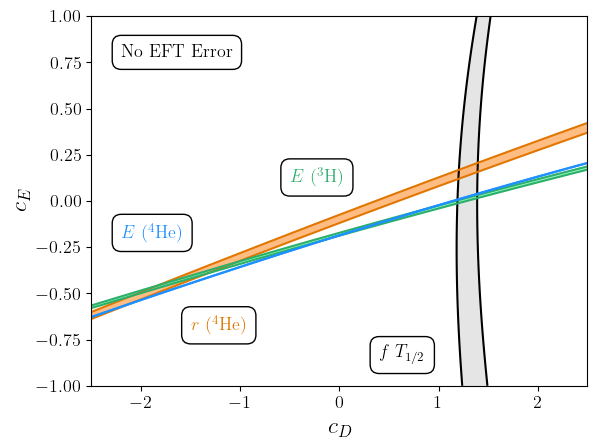

In [9]:

def constraint_plotter(cD_eval, cE_eval, efterror=False):

    E4He_eval, Rp4He_eval, _, E3He_eval, E3H_eval, _, fT3H_eval = vfewnucleonEmulator(cD_eval, cE_eval)
            
    fig, ax = plt.subplots()

    x = 1

    mean_E4He = -28.296 # np.mean(E4He_eval)
    mean_Rp4He = 1.4552  # np.mean(Rp4He_eval)
    mean_E3H = -8.482 # np.mean(E3H_eval) 
    mean_fT3H = 1129.6 #np.mean(fT3H_eval)

    sigma_E3H = 0.015
    sigma_E4He = 0.005
    sigma_Rp4He = 0.0062
    sigma_fT3H = 3.

    if efterror:
        sigma_E3H = np.sqrt(0.015 + (1 * 0.33**4 * -8.482)**2/(1 - 0.33**2))
        sigma_E4He = np.sqrt(0.005 + (1 * 0.33**4 * -28.296)**2/(1 - 0.33**2))
        sigma_Rp4He = np.sqrt(0.0062 + (1 * 0.33**4 * 1.4552)**2/(1 - 0.33**2))
        sigma_fT3H = np.sqrt(3. + (1 * 0.33**4 * 1129.6)**2/(1 - 0.33**2))
        ax.text(-2.2, 0.7, 'With EFT Error \n $\\bar{c}=1$, $Q=0.33$', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    else:
        ax.text(-2.2, 0.78, 'No EFT Error', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)

    cs= ax.contourf(cD_eval, cE_eval, fT3H_eval, levels=[mean_fT3H-x*sigma_fT3H, mean_fT3H+x*sigma_fT3H], colors='gray', alpha=0.2)
    contour_lines = ax.contour(cs, levels=cs.levels[:3], colors='black')
    cs = ax.contourf(cD_eval, cE_eval, Rp4He_eval, levels=[mean_Rp4He-x*sigma_Rp4He, mean_Rp4He+x*sigma_Rp4He], colors='#ffb16d', alpha=0.85)
    contour_lines = ax.contour(cs, levels=cs.levels[:3], colors='#e17701')
    cs = ax.contourf(cD_eval, cE_eval, E3H_eval, levels=[mean_E3H-x*sigma_E3H, mean_E3H+x*sigma_E3H], colors='#7af9ab', alpha=0.8)
    contour_lines = ax.contour(cs, levels=cs.levels[:3], colors='#2baf6a', linestyles='-')
    cs = ax.contourf(cD_eval, cE_eval, E4He_eval, levels=[mean_E4He-x*sigma_E4He, mean_E4He+x*sigma_E4He], colors='dodgerblue', alpha=0.5)
    contour_lines = ax.contour(cs, levels=cs.levels[:3], colors='dodgerblue', linestyles='-')

    return ax

def customizer(ax):

    ax.set_xlabel('$c_D$', fontsize=font_size+4)
    ax.set_ylabel('$c_E$', fontsize=font_size+4)
    ax.text(0.4, -0.85, '$f$ $T_{1/2}$', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    ax.text(-1.5, -0.7, '$r$ ($^4$He)', color='#e17701', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    ax.text(-0.5, .1, '$E$ ($^3$H)', color='#2baf6a', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    ax.text(-2.2, -0.2, '$E$ ($^4$He)', color='dodgerblue', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    ax.tick_params(axis='x', labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)

save = False
efterror = False

### Comment after one use for customization of text boxes by changing
### the customizer function
ax = constraint_plotter(cD_eval, cE_eval, efterror=efterror)

for txt in ax.texts[1:]:
    txt.set_visible(False)
    ax.texts[1:].remove(txt)

customizer(ax)

fig = ax.get_figure()
if efterror and save:
    fig.savefig('figs/constraints_EFT_exp.pdf', bbox_inches='tight')
elif save:
    fig.savefig('figs/constraints_noEFT_exp.pdf', bbox_inches='tight')


In [10]:
import emcee
import scipy.stats as stats
import corner

sigma_E3H = np.sqrt(0.015 + (1 * 0.33**4 * -8.482)**2/(1 - 0.33**2))
sigma_E4He = np.sqrt(0.005 + (1 * 0.33**4 * -28.296)**2/(1 - 0.33**2))
sigma_Rp4He = np.sqrt(0.0062 + (1 * 0.33**4 * 1.4552)**2/(1 - 0.33**2))
sigma_fT3H = np.sqrt(3. + (1 * 0.33**4 * 1129.6)**2/(1 - 0.33**2))

def log_prior(params):
    
    cD, cE = params
    cD_mu = 0.
    cD_sigma = 5
    cE_mu = 0.
    cE_sigma = 5

    return (np.sum(stats.norm.logpdf(cD, loc=cD_mu, scale=cD_sigma)) + 
            np.sum(stats.norm.logpdf(cE, loc=cE_mu, scale=cE_sigma)))   

def log_likelihood(params, data_set):
    cD, cE = params
    E4He, Rp4He, _, _, E3H, _, fT3H = vfewnucleonEmulator(cD, cE)

    # mean_E4He = np.mean(E4He) # -28.296
    # mean_Rp4He = np.mean(Rp4He) # 1.4552
    # mean_E3H = np.mean(E3H) # -8.482
    # mean_fT3H = np.mean(fT3H) # 1129.6

    if len(data_set) == 2:
        return (np.sum(stats.norm.logpdf(E4He, -28.296, sigma_E4He)) + 
                np.sum(stats.norm.logpdf(Rp4He, 1.4552, sigma_Rp4He)))
    elif len(data_set) == 4:
        return (np.sum(stats.norm.logpdf(E4He, -28.296, sigma_E4He)) +
                np.sum(stats.norm.logpdf(Rp4He, 1.4552, sigma_Rp4He)) +
                np.sum(stats.norm.logpdf(E3H, -8.482, sigma_E3H)) +
                np.sum(stats.norm.logpdf(fT3H, 1129.6, sigma_fT3H)))

def log_posterior(params, data_set):
    return log_prior(params) + log_likelihood(params, data_set)

cD_0 = np.random.normal(0., 5, 50)
cE_0 = np.random.normal(0., 5, 50)

pos = np.vstack((cD_0, cE_0))

nwalkers, ndim = pos.T.shape

E4He, Rp4He, _, _, E3H, _, fT3H = vfewnucleonEmulator(cD_0, cE_0)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_posterior, args=[(E4He, Rp4He, E3H, fT3H)])
burn = sampler.run_mcmc(pos.T, 100, progress=True)
sampler.reset()

sampler.run_mcmc(burn, 1000, progress=True)

100%|██████████| 1000/1000 [00:19<00:00, 51.66it/s]


State([[ 1.20232267e+00  5.86340404e-02]
 [ 9.83923624e-01 -1.17723681e-02]
 [ 8.82378658e-01 -1.88705893e-02]
 [ 6.40840844e-01 -1.40098689e-02]
 [ 1.23497866e+00 -3.15432299e-02]
 [ 1.70781800e+00  4.93676115e-02]
 [ 1.36038196e+00  3.63339705e-02]
 [ 1.05728232e+00  3.17340534e-04]
 [ 1.68392792e+00  1.28393517e-01]
 [ 1.20999807e+00  1.01871144e-03]
 [ 8.51632382e-01  3.16214414e-02]
 [ 1.54217498e+00  6.45407418e-02]
 [ 1.35687239e+00  8.68494584e-02]
 [ 1.45462454e+00  6.71566341e-02]
 [ 1.71921339e+00  1.24666373e-01]
 [ 1.17649497e+00  3.76469014e-02]
 [ 1.10104466e+00 -2.00006433e-02]
 [ 1.87413511e+00  1.27246621e-01]
 [ 1.48312448e+00  4.28027461e-02]
 [ 1.28097750e+00  6.27793842e-02]
 [ 1.29503608e+00 -4.76734958e-02]
 [ 1.21119530e+00  4.39157608e-02]
 [ 1.61343603e+00  8.19111335e-02]
 [ 1.88118957e+00  1.46670076e-01]
 [ 1.29040882e+00  2.71931255e-02]
 [ 1.81714877e+00  1.29099493e-01]
 [ 1.11229082e+00 -3.39716891e-02]
 [ 1.07287951e+00 -2.17788743e-02]
 [ 1.79884645e

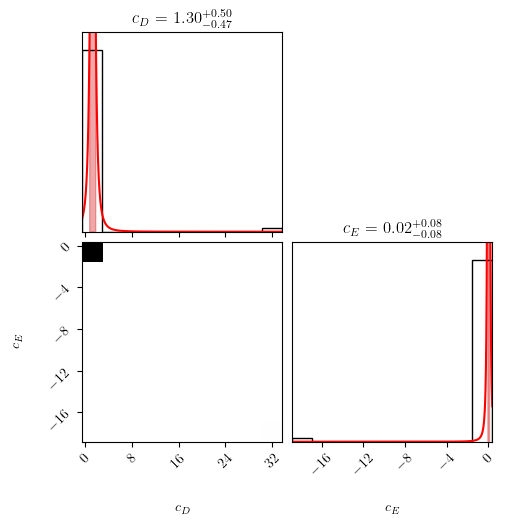

In [14]:
samples = sampler.get_chain(flat=True)
#plt.hist(samples[:, 1], 1000, color="k", histtype="step")
#plt.xlim(-1, 1)
#plt.show()

flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)
fig = corner.corner(flat_samples, labels=[r"$c_D$", r"$c_E$"], color='k',
                show_titles=True, bins=10,plot_datapoints=False,)#,levels=0.68)#,quantiles=[0.16,0.5,0.84])

for i in range(flat_samples.shape[1]):
    ### Diagonal indices of the corner plot
    ax = fig.get_axes()[i * (len(flat_samples[1]) + 1)]

    # Each 'poly' is a Polygon object; we can extract the vertices
    verts = ax.patches[0].get_xy()  # Get the vertices of the polygon
    # Remove duplicate vertices

    # The x-values represent the bin edges, y-values represent the heights
    bin_left_edges = verts[:, 0]  # X-coordinates (bin edges)
    bin_heights = verts[:, 1]  # Y-coordinates (heights)
    bin_width = np.diff(bin_left_edges)[1]  # Width of each bin

    # Fit a t-distribution to the histogram data
    df, loc, scale = stats.t.fit(flat_samples[:, i])  # Fit t-distribution to the i-th parameter
    area = np.sum(bin_width/2 * bin_heights)  # Total area under the histogram

    # Generate the t-distribution PDF using the fitted parameters
    x = np.linspace(bin_left_edges.min(), bin_left_edges.max(), 1000)
    pdf_fitted = stats.t.pdf(x, df=df, loc=loc, scale=scale) * area
    # Plot the t-distribution PDF over the histogram
    ax.plot(x, pdf_fitted, 'r-')

    cred_region = 0.84
    t_value_lower = stats.t.ppf((1-cred_region)/2, df=10, loc=loc, scale=scale)
    t_value_upper = stats.t.ppf(cred_region + ((1-cred_region)/2), df=10, loc=loc, scale=scale)

    ax.fill_between(x, pdf_fitted, where=((x >= t_value_lower) & (x <= t_value_upper)), 
                color='tab:red', alpha=0.4)
    


#ax = fig.get_axes()[2]
## Define the angle step and the range of angles to draw
#angle_step = 45  ## degrees
#angles = np.arange(0, 180, angle_step)

#for angle in angles:
#ellipse = Ellipse((1.3, 0), 2, 0.05, angle=45, alpha=0.9)
#ax.add_artist(ellipse)
#plt.show()
    # Optionally, add a legend
    #ax.legend()